In [98]:
# default libraries
import pathlib
import zipfile

# Import installed libraries
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import tensorflow as tf

# Matplotlib darkmode
plt.style.use('dark_background')

# Styling
plt.rcParams.update({
    "font.size": 14
})


In [99]:
# Read in the level 1 data
cal_df = pd.read_pickle("../data/level1/CDA__CAT_IID_cal_data.pkl")

In [100]:
# unweighted calibration ml model for IID
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)].copy()

# Adding the LOG10 scaled data of the QI channel
iid_qi_cal_df.loc[:, "QI_LOG10_CHARGE"] = np.log10(iid_qi_cal_df["QI_CHARGE"])

# Considering only "relevant" data: rise time, log10 charge and the velocity
# iid_qi_cal_df = iid_qi_cal_df[["QI_TR", "QI_LOG10_CHARGE", "PSU_VEL"]]

In [101]:
iid_qi_cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS,QI_LOG10_CHARGE
829,4.09,31.3600,0,2000000,43.9482,57.00,206.00900,14.83,176.9120,46.67,IID,7.498760e-15,1.642941
830,4.07,31.9200,0,2000000,42.6352,54.00,166.73900,16.33,204.9460,43.67,IID,7.707864e-15,1.629768
831,4.10,30.6600,0,2000000,48.6620,59.16,187.83500,21.34,189.8550,44.34,IID,7.295657e-15,1.687190
832,4.11,33.3200,0,2000000,51.0875,59.50,174.90200,18.50,211.9450,44.00,IID,7.890079e-15,1.708315
833,4.07,74.9000,0,2000000,130.3050,55.67,415.97200,12.83,428.5020,39.33,IID,1.808644e-14,2.114961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,7.93,4.5087,0,2000000,12.9795,32.17,7.54071,18.67,48.9116,32.33,IID,2.867906e-16,1.113258
3742,8.23,4.9609,0,2000000,16.3490,28.84,37.73430,18.66,52.7411,25.67,IID,2.929684e-16,1.213491
3743,8.21,3.9368,0,2000000,13.3384,37.50,18.02220,18.67,42.9590,40.67,IID,2.336238e-16,1.125104
3744,7.84,4.2826,0,2000000,14.6953,19.33,14.16240,32.33,55.5990,19.67,IID,2.786990e-16,1.167178


In [102]:
iid_qi_cal_df.describe()

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,MASS,QI_LOG10_CHARGE
count,1634.000000,1634.000000,1634.0,1.634000e+03,1634.000000,1634.000000,1.634000e+03,1634.000000,1.634000e+03,1634.000000,1.634000e+03,1634.000000
mean,10.036346,20.161700,0.0,1.983048e+06,53.210788,40.512815,3.392901e+15,16.556408,3.695838e+15,39.712827,6.519395e-15,1.416504
std,9.302421,29.037159,0.0,9.312044e+04,71.322299,16.762827,1.801622e+16,10.291624,1.877350e+16,21.288395,1.764761e-14,0.524261
min,1.590000,0.840000,0.0,1.350000e+06,0.461755,0.340000,-1.867510e-01,0.000000,-8.681840e+00,0.000000,1.118135e-18,-0.335588
25%,4.230000,3.657675,0.0,2.000000e+06,11.650400,26.500000,2.988340e+01,10.000000,4.005070e+01,24.000000,1.713061e-16,1.066341
50%,7.030000,9.380000,0.0,2.000000e+06,23.205300,44.000000,7.199450e+01,17.335000,9.884825e+01,43.660000,7.687655e-16,1.365587
75%,11.075000,23.370375,0.0,2.000000e+06,63.704750,53.170000,1.634565e+02,23.660000,3.050810e+02,56.000000,3.881211e-15,1.804166
max,69.700000,385.000000,0.0,2.000000e+06,710.416000,89.830000,9.900000e+16,58.840000,9.900000e+16,99.670000,2.976114e-13,2.851513


Text(0.5, 0, 'PSU velocity in km/s')

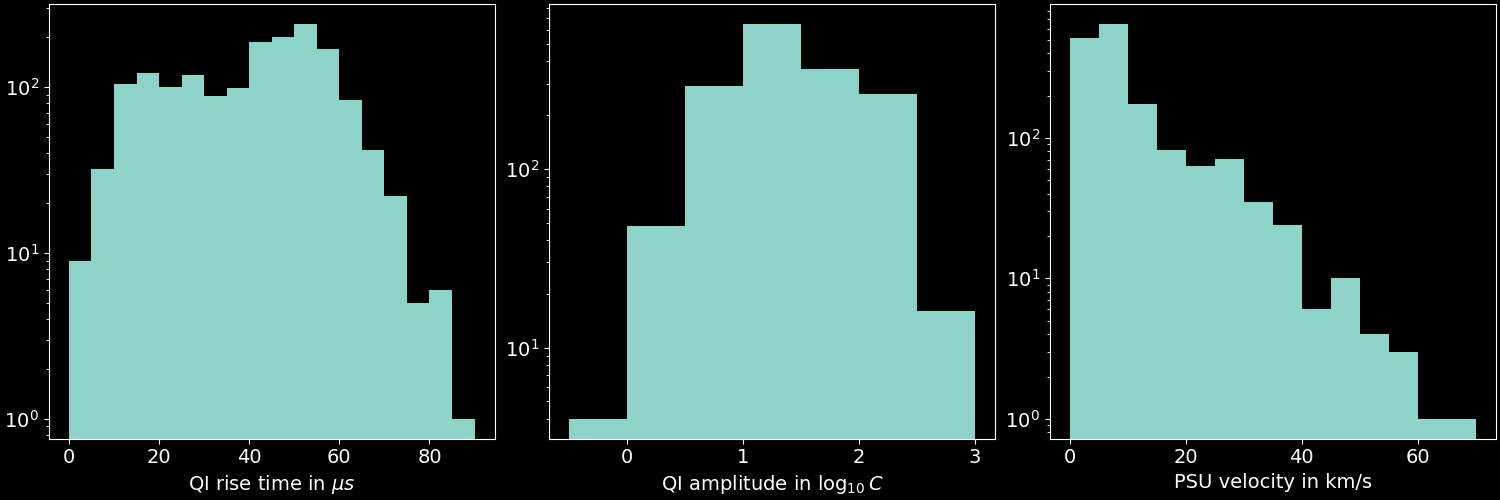

In [103]:
# histograms of distributions before spliting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    layout="constrained",
                                    sharey=False,
                                    figsize=(15,5))

# add the QI rise time
ax1.hist(iid_qi_cal_df["QI_TR"], bins=np.arange(0,95,5))
ax1.set_xlabel("QI rise time in " + r"$\mu s$")
ax1.set_yscale("log")

# QI amplitude
ax2.hist(iid_qi_cal_df["QI_LOG10_CHARGE"], bins=np.arange(-0.5,3.5,0.5))
ax2.set_yscale("log")
ax2.set_xlabel("QI amplitude in " + r"$\log_{10} C$")

# psu velocity
ax3.hist(iid_qi_cal_df["PSU_VEL"], bins=np.arange(0, 75, 5))
ax3.set_yscale("log")
ax3.set_xlabel("PSU velocity in km/s")

In [104]:
iid_qi_vel = iid_qi_cal_df[["QI_TR", "QI_LOG10_CHARGE", "PSU_VEL"]].values

iid_qi_vel[0]

array([57.        ,  1.64294109,  4.09      ])

In [105]:

# Additionally, shuffle the data to be REALLY sure that there is no "order bias"
np.random.shuffle(iid_qi_vel)

In [106]:
iid_qi_vel[0]

array([14.84      ,  2.26263616, 25.6       ])

In [107]:
# split the data in training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(iid_qi_vel[:,:2],
                                                                            iid_qi_vel[:,-1],
                                                                            test_size=0.2)



In [108]:
X_train

array([[33.83      ,  1.3989984 ],
       [45.33      ,  1.46121931],
       [47.84      ,  1.06677304],
       ...,
       [44.16      ,  1.25389748],
       [56.        ,  1.3989984 ],
       [40.5       ,  0.87899891]])

In [109]:
psu_vel_bins = np.arange(0,95,5)
qi_tr_bins = np.arange(0,100,10)
qi_ampl_bins = np.arange(-0.5,3.5,0.5)

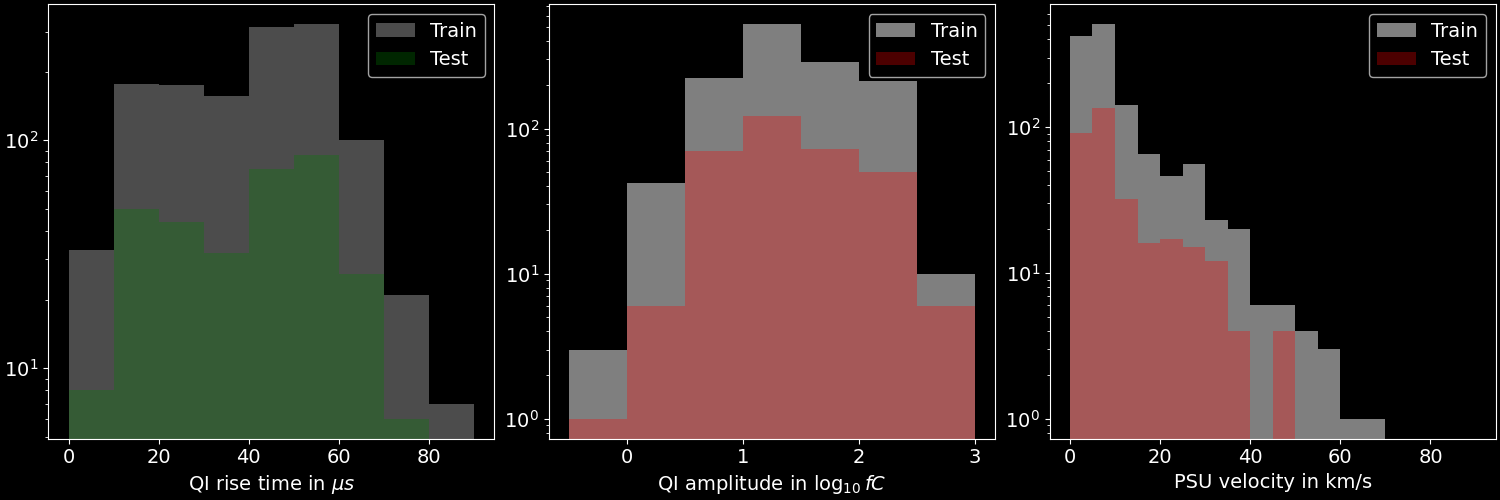

In [110]:
# after spliting unweighted distribution histogram plots

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    layout="constrained",
                                    sharey=False,
                                    figsize=(15,5))

ax1.hist(X_train[:, 0], bins=qi_tr_bins, alpha=0.3, color="white", label="Train")
ax1.hist(X_test[:, 0], bins=qi_tr_bins, alpha=0.3, color="green", label="Test")
ax1.set_yscale("log")
ax1.set_xlabel("QI rise time in " + r"$\mu s$")

ax1.legend(loc="upper right")

# Add the QI Amplitude
ax2.hist(X_train[:, 1], bins=qi_ampl_bins, alpha=0.5, color="white", label="Train")
ax2.hist(X_test[:, 1], bins=qi_ampl_bins, alpha=0.3, color="red", label="Test")
ax2.set_yscale("log")
ax2.set_xlabel("QI amplitude in " + r"$\log_{10} fC$")

ax2.legend(loc="upper right")

# Add the PSU velocity
ax3.hist(y_train, bins=psu_vel_bins, alpha=0.5, color="white", label="Train")
ax3.hist(y_test, bins=psu_vel_bins, alpha=0.3, color="red", label="Test")
ax3.set_yscale("log")
ax3.set_xlabel("PSU velocity in km/s")

ax3.legend(loc="upper right")

In [111]:
# shaping for the neural network datasets
print(f"Before reshaping: {y_train.shape}")

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"After reshaping: {y_train.shape}")

Before reshaping: (1307,)
After reshaping: (1307, 1)


In [112]:
# standardization
X_scaler = sklearn.preprocessing.StandardScaler()
y_scaler = sklearn.preprocessing.StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [113]:
# resulting mean and std of the data
print(f"Mean of the training features: {X_train_scaled.mean(axis=0)}")
print(f"Standard Deviation of the training features: {X_train_scaled.std(axis=0)}")

Mean of the training features: [-7.17697043e-16 -4.66174748e-15]
Standard Deviation of the training features: [1. 1.]


MACHINE LEARNING Training with simple neural network

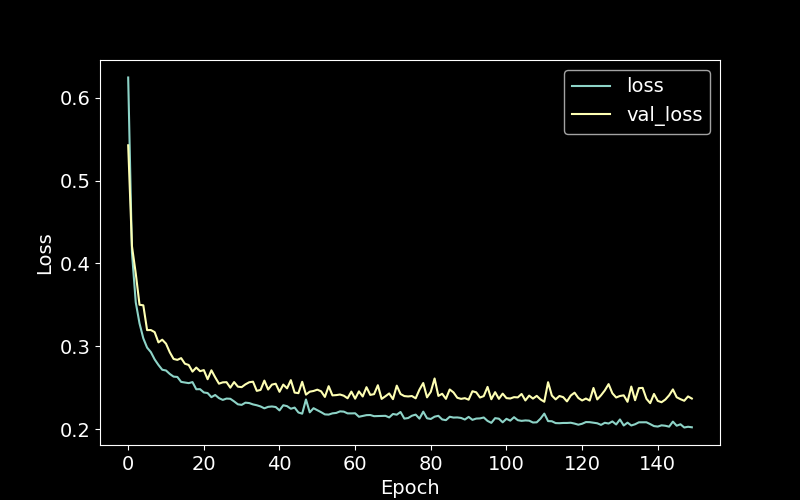

In [114]:
# neural network wirh 2 hidden layers in this first regression

# input shape is 2: rise time and charge
inputs = tf.keras.Input(shape=(2,),
                        name="iid_qi_data",)

# 2 hidden layers
layer = tf.keras.layers.Dense(units=64, activation="relu",)(inputs)
layer = tf.keras.layers.Dense(units=32, activation="relu",)(layer)

# output layer with only 1 unit mapping to get the results of velocity vallues
output = tf.keras.layers.Dense(units=1, name="psu_vel",)(layer)

# we use model API rather than sequential
model = tf.keras.Model(inputs=inputs, outputs=output)

# lots of different losses and metrics
model.compile(optimizer="adam",
            loss=["mean_squared_error"],
            metrics=[tf.keras.metrics.RootMeanSquaredError(),
                    "mean_absolute_error"])

model.fit(x=X_train_scaled,
        y=y_train_scaled,
        batch_size=32,
        epochs=150,
        validation_split=0.25,
        verbose=0)

plt.figure(figsize=(8,5))
plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.xlabel(f"Epoch")
plt.ylabel(f"Loss")
plt.legend()

In [115]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ iid_qi_data (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ psu_vel (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,917 (27.02 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,612 (18.02 KB)

In [116]:
# evaluating model in the standardized scale
_, mae_scaled, rmse_scaled = model.evaluate(X_test_scaled, y_test_scaled)

rmse = y_scaler.inverse_transform([[rmse_scaled]])
mae = y_scaler.inverse_transform([[mae_scaled]])

print(f"RMSE on test data in km/s : {rmse[0][0]}")
print(f"MAE on test data in km/s: {mae[0][0]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1839 - mean_absolute_error: 0.2548 - root_mean_squared_error: 0.4266
RMSE on test data in km/s : 12.495882379971865
MAE on test data in km/s: 14.402764265382785


In [117]:
# rescaling the data to fit the 3d mesh for a hyperplane passing through
# the values in 3d scatter earlier
min_rt, min_log10ampl = X_scaler.transform([[1, 0.5]])[0]
max_rt, max_log10ampl = X_scaler.transform([[60, 2.6]])[0]


# generate linspaced values in between to fit the grid
rise_time_range_scaled = np.linspace(min_rt,
                                    max_rt,
                                    100)

log_fc_range_scaled = np.linspace(min_log10ampl,
                                max_log10ampl,
                                100)

rise_time_range_scaled, log_fc_range_scaled = np.meshgrid(rise_time_range_scaled,
                                                        log_fc_range_scaled)



In [118]:
rise_time_range_scaled

array([[-2.37796361, -2.34218761, -2.30641161, ...,  1.09230823,
         1.12808422,  1.16386022],
       [-2.37796361, -2.34218761, -2.30641161, ...,  1.09230823,
         1.12808422,  1.16386022],
       [-2.37796361, -2.34218761, -2.30641161, ...,  1.09230823,
         1.12808422,  1.16386022],
       ...,
       [-2.37796361, -2.34218761, -2.30641161, ...,  1.09230823,
         1.12808422,  1.16386022],
       [-2.37796361, -2.34218761, -2.30641161, ...,  1.09230823,
         1.12808422,  1.16386022],
       [-2.37796361, -2.34218761, -2.30641161, ...,  1.09230823,
         1.12808422,  1.16386022]])

In [119]:
log_fc_range_scaled

array([[-1.76194292, -1.76194292, -1.76194292, ..., -1.76194292,
        -1.76194292, -1.76194292],
       [-1.7211132 , -1.7211132 , -1.7211132 , ..., -1.7211132 ,
        -1.7211132 , -1.7211132 ],
       [-1.68028348, -1.68028348, -1.68028348, ..., -1.68028348,
        -1.68028348, -1.68028348],
       ...,
       [ 2.19853996,  2.19853996,  2.19853996, ...,  2.19853996,
         2.19853996,  2.19853996],
       [ 2.23936968,  2.23936968,  2.23936968, ...,  2.23936968,
         2.23936968,  2.23936968],
       [ 2.2801994 ,  2.2801994 ,  2.2801994 , ...,  2.2801994 ,
         2.2801994 ,  2.2801994 ]])

In [120]:
np.hstack([rise_time_range_scaled, log_fc_range_scaled])

array([[-2.37796361, -2.34218761, -2.30641161, ..., -1.76194292,
        -1.76194292, -1.76194292],
       [-2.37796361, -2.34218761, -2.30641161, ..., -1.7211132 ,
        -1.7211132 , -1.7211132 ],
       [-2.37796361, -2.34218761, -2.30641161, ..., -1.68028348,
        -1.68028348, -1.68028348],
       ...,
       [-2.37796361, -2.34218761, -2.30641161, ...,  2.19853996,
         2.19853996,  2.19853996],
       [-2.37796361, -2.34218761, -2.30641161, ...,  2.23936968,
         2.23936968,  2.23936968],
       [-2.37796361, -2.34218761, -2.30641161, ...,  2.2801994 ,
         2.2801994 ,  2.2801994 ]])

In [121]:
# plotting the z-axis with the help of meshgrid
rise_time_range = []
log_fc_range = []
pred_vel = []

for _rt, _fc in zip(rise_time_range_scaled, log_fc_range_scaled):
     stacked_scaled = np.hstack([_rt.reshape(-1,1),
                                _fc.reshape(-1,1)])

     # rise time and log_fc scalings
     rise_time_range.append(X_scaler.inverse_transform(stacked_scaled)[:, 0])
     log_fc_range.append(X_scaler.inverse_transform(stacked_scaled)[:,1])

     # pred. vel. stacked scaling
     temp_results = model.predict(x=stacked_scaled)
     pred_vel.append(y_scaler.inverse_transform(temp_results.reshape(1,-1))[0])

pred_vel = np.array(pred_vel)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step

In [122]:
stacked_scaled[0]

array([-2.37796361,  2.2801994 ])

In [123]:
iid_qi_cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS,QI_LOG10_CHARGE
829,4.09,31.3600,0,2000000,43.9482,57.00,206.00900,14.83,176.9120,46.67,IID,7.498760e-15,1.642941
830,4.07,31.9200,0,2000000,42.6352,54.00,166.73900,16.33,204.9460,43.67,IID,7.707864e-15,1.629768
831,4.10,30.6600,0,2000000,48.6620,59.16,187.83500,21.34,189.8550,44.34,IID,7.295657e-15,1.687190
832,4.11,33.3200,0,2000000,51.0875,59.50,174.90200,18.50,211.9450,44.00,IID,7.890079e-15,1.708315
833,4.07,74.9000,0,2000000,130.3050,55.67,415.97200,12.83,428.5020,39.33,IID,1.808644e-14,2.114961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,7.93,4.5087,0,2000000,12.9795,32.17,7.54071,18.67,48.9116,32.33,IID,2.867906e-16,1.113258
3742,8.23,4.9609,0,2000000,16.3490,28.84,37.73430,18.66,52.7411,25.67,IID,2.929684e-16,1.213491
3743,8.21,3.9368,0,2000000,13.3384,37.50,18.02220,18.67,42.9590,40.67,IID,2.336238e-16,1.125104
3744,7.84,4.2826,0,2000000,14.6953,19.33,14.16240,32.33,55.5990,19.67,IID,2.786990e-16,1.167178


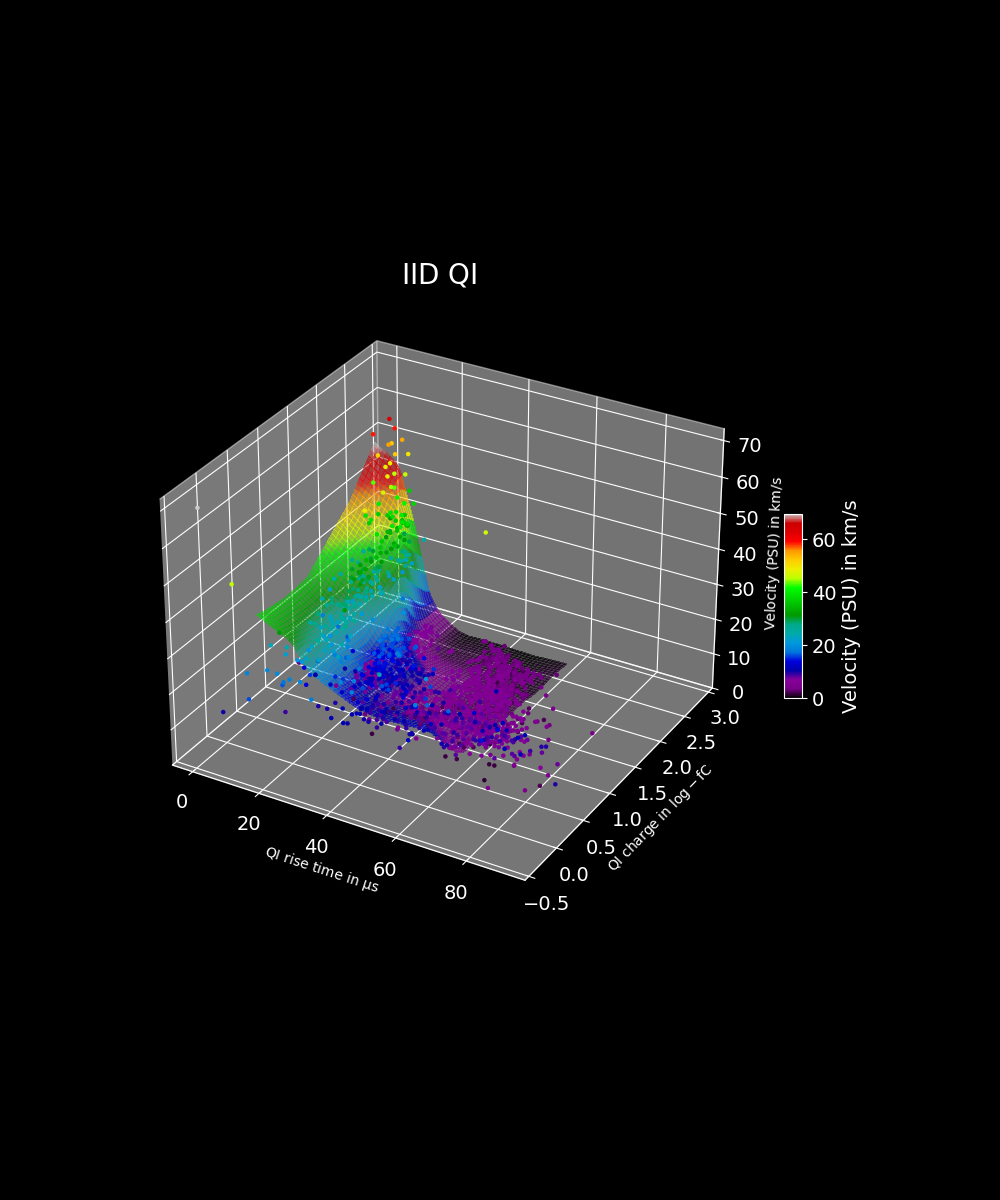

In [126]:
%matplotlib widget

# channel
ch = "QI"

# 3D plot
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection="3d")

# scatter plot with log10 charges
sc = ax.scatter(iid_qi_cal_df[ch + '_TR'],
                np.log10(iid_qi_cal_df[ch + '_CHARGE']),
                iid_qi_cal_df['PSU_VEL'],
                c=iid_qi_cal_df['PSU_VEL'],
                cmap="nipy_spectral",
                vmin=0,
                vmax=np.max(iid_qi_cal_df["PSU_VEL"]),
                marker=".",
                alpha=1,
                zorder=0)

ax.set_title(rf"$\mathrm{{IID\ {ch}}}$", fontsize=20)

ax.set_xlabel(rf"$\mathrm{{{ch}\ rise\ time\ in\ \mu s}}$", fontsize=10)
ax.set_ylabel(rf"$\mathrm{{{ch}\ charge\ in\ log-fC}}$", fontsize=10)
ax.set_zlabel(rf"$\mathrm{{Velocity\ (PSU)\ in\ km/s}}$", fontsize=10)

ax.set_zlim(0, 1.05 * np.max(iid_qi_cal_df["PSU_VEL"]))
ax.tick_params(labelsize=14)

# add a regression line
ax.plot_surface(rise_time_range,
                log_fc_range,
                pred_vel,
                cmap="nipy_spectral",
                linewidth=0,
                antialiased=False,
                alpha=0.5)

# create a colorbar
cbar = fig.colorbar(sc,
                    shrink=0.2,
                    aspect=10,
                    orientation="vertical",
                    pad=0.04)

cbar.ax.tick_params(labelsize=14)
cbar.set_label(label=r"Velocity (PSU) in km/s",
                size=14)

plt.show()
